In [ ]:
# In this collab book, I have implemented SE-Resnet Architechture.
# I have trained the architecture from scratch and achieved 80% accuracy on the Test Set.
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import os
import time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [ ]:
# This is the SE Residual Block.
# First the Residual Block followed by the SE Block.
class SEResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(SEResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


In [ ]:
# Here we have made SE-Resnet-18 model.
class SEResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(SEResNet, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.in_channels, planes, stride, downsample))
        self.in_channels = planes
        for i in range(1, blocks):
            layers.append(block(self.in_channels, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x    


In [ ]:
num_classes = 10
num_epochs = 20
batch_size = 16
learning_rate = 0.01

# Just checking the accuracy with SE-Resnet-18 architecture.
model = SEResNet(SEResidualBlock, [2,2,2,2]).to(device)  # We can modify this line to make it either Resnet-34 or Resnet-18

In [ ]:
print(model)

SEResNet(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): SEResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_features=64, bias=False)
          

In [ ]:
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

# Train the model
total_step = len(trainloader)
print(total_step)

3125


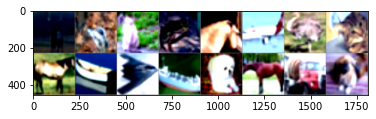

deer  bird  cat   frog  horse plane bird  cat   horse ship  plane ship  dog   horse truck dog  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
print(len(trainset))

50000


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=10):
    since = time.time()
    
    acc_history = []
    loss_history = []

    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # backward
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        
        torch.save(model.state_dict(), os.path.join('/content/data', '{0:0=2d}.pth'.format(epoch)))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [ ]:
train_acc_hist, train_loss_hist = train_model(model, trainloader, criterion, optimizer, device)

Epoch 0/9
----------
Loss: 1.4496 Acc: 0.4684

Epoch 1/9
----------
Loss: 0.9191 Acc: 0.6755

Epoch 2/9
----------
Loss: 0.7229 Acc: 0.7509

Epoch 3/9
----------
Loss: 0.6243 Acc: 0.7876

Epoch 4/9
----------
Loss: 0.5607 Acc: 0.8100

Epoch 5/9
----------
Loss: 0.5202 Acc: 0.8255

Epoch 6/9
----------
Loss: 0.4926 Acc: 0.8332

Epoch 7/9
----------
Loss: 0.4762 Acc: 0.8394

Epoch 8/9
----------
Loss: 0.4529 Acc: 0.8477

Epoch 9/9
----------
Loss: 0.4321 Acc: 0.8532

Training complete in 31m 8s
Best Acc: 0.853240


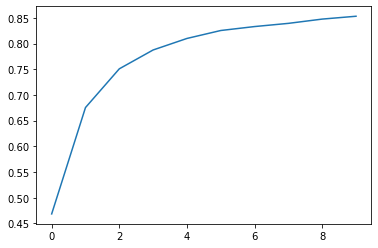

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_acc_hist)

In [ ]:
def test_model(model, test_loader):
# prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    total=0
    correct=0
    model.eval()
    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            total += labels.size(0)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct += 1
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
            test_accuracy = 100* correct/total
    print('Test accuracy: {}%'.format(test_accuracy))
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
test_model(model, testloader)

Test accuracy: 82.41%
Accuracy for class: plane is 89.3 %
Accuracy for class: car   is 95.2 %
Accuracy for class: bird  is 71.1 %
Accuracy for class: cat   is 53.3 %
Accuracy for class: deer  is 78.5 %
Accuracy for class: dog   is 75.0 %
Accuracy for class: frog  is 92.3 %
Accuracy for class: horse is 91.1 %
Accuracy for class: ship  is 91.3 %
Accuracy for class: truck is 87.0 %
